### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler
from imblearn.over_sampling import RandomOverSampler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import smote_variants as sv

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

### Working with dataset 1 : European credit card transactions dataset  by Machine Learning group of University of Brussels

In [4]:
data = pd.read_csv("creditcard.csv")

data.head()

data['Class'].value_counts()

len(data['Class'])

print("percentage of fraudulent data instances: {}".format(data['Class'].value_counts()[1] *100 /len(data['Class'])))
print("percentage of normal data instances: {}".format(data['Class'].value_counts()[0] *100 /len(data['Class'])))

# Rescaling the data



rs = RobustScaler()

data['scaled_amount'] = rs.fit_transform(data['Amount'].values.reshape(-1, 1))
data['scaled_time'] = rs.fit_transform(data['Time'].values.reshape(-1, 1))

data.drop(['Amount', 'Time'], axis = 1, inplace = True)



X = data.drop(['Class'], axis = 1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0, 
                                                    stratify = y)

print(X_train.shape, y_train.shape)
print(y_train.value_counts())



percentage of fraudulent data instances: 0.1727485630620034
percentage of normal data instances: 99.827251436938
(199364, 30) (199364,)
0    199020
1       344
Name: Class, dtype: int64


In [6]:
all_dataset=dict()

In [7]:
all_results=[]

In [9]:
 def training_testing_function(X,y,name):
        
        #removing highly correlated features
        corr = X.corr()
        columns = np.full((corr.shape[0],), True, dtype=bool)
        for i in range(corr.shape[0]):
            for j in range(i+1, corr.shape[0]):
                if abs(corr.iloc[i,j]) > 0.5:
                    if columns[j]:
                        columns[j] = False
        selected_columns = X.columns[columns]
        X1 = X[selected_columns]
        

        # Train LogisticRegression Model
        LGR_Classifier = LogisticRegression(multi_class='auto', random_state=1,solver='lbfgs',max_iter=200)
        LGR_Classifier.fit(X1, y.values.ravel())

        # Train Gaussian Naive Baye Model
        GNB_Classifier = GaussianNB()
        GNB_Classifier.fit(X1,y.values.ravel())

        # Train Decision Tree Model
        DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
        DTC_Classifier.fit(X1, y.values.ravel());
        
        XGB_Classifier = XGBClassifier(scale_pos_weight=500)
        XGB_Classifier.fit(X1,y.values.ravel())
        
        

        ## Train combined model (This method combines all the individual models above)
        combined_model = [('Naive Baye Classifier', GNB_Classifier), 
                         ('Decision Tree Classifier', DTC_Classifier), 
                         ('LogisticRegression', LGR_Classifier),
                          ('Gradient Boosting Classifier', XGB_Classifier)
                        ]
        VC =  VotingClassifier(estimators = combined_model,voting = 'soft')
        VC.fit(X1, y.values.ravel());

        models = [('Naive Baye Classifier', GNB_Classifier), 
                         ('Decision Tree Classifier', DTC_Classifier), 
                         ('LogisticRegression', LGR_Classifier),
                          ('Gradient Boosting Classifier', XGB_Classifier),
                  ('VotingClassifier', VC)]

        for i, v in models:
            accuracy = metrics.accuracy_score(y_test.values.ravel(), v.predict(X_test[selected_columns]))
            f1 = metrics.f1_score(y_test.values.ravel(),v.predict(X_test[selected_columns]))
            auc_score = metrics.roc_auc_score(y_test.values.ravel(),v.predict(X_test[selected_columns]))
            confusion_matrix = metrics.confusion_matrix(y_test.values.ravel(), v.predict(X_test[selected_columns]))
            classification = metrics.classification_report(y_test.values.ravel(), v.predict(X_test[selected_columns]))

            
            all_results.append((name+" "+i+str(" RCF"),accuracy,f1,auc_score,confusion_matrix,classification)) #RCF = Removing correlated features
            print("{} Completed".format(name +" "+i+str(" RCF")))
        
        
        
        
      

        rfc = RandomForestClassifier();

        # fit random forest classifier on the training set
        rfc.fit(X, y.values.ravel());
        # extract important features
        score = np.round(rfc.feature_importances_,3)

        importances = pd.DataFrame({'feature':X.columns,'importance':score})
        importances = importances.sort_values('importance',ascending=False).set_index('feature')

        min_features=min(len(importances),20)
        
        final_features=list(importances[:20].index)

        X2=X[final_features]

    

        # Train LogisticRegression Model
        LGR_Classifier = LogisticRegression(multi_class='auto', random_state=1,solver='lbfgs',max_iter=200)
        LGR_Classifier.fit(X2, y.values.ravel())

        # Train Gaussian Naive Baye Model
        GNB_Classifier = GaussianNB()
        GNB_Classifier.fit(X2, y.values.ravel())

        # Train Decision Tree Model
        DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
        DTC_Classifier.fit(X2, y.values.ravel())
        
        XGB_Classifier = XGBClassifier(scale_pos_weight=500)
        XGB_Classifier.fit(X2,y.values.ravel())

        ## Train comvined model (This method combines all the individual models)
        combined_model = [('Naive Baye Classifier', GNB_Classifier), 
                         ('Decision Tree Classifier', DTC_Classifier), 
                         ('LogisticRegression', LGR_Classifier),
                        ('Gradient Boosting Classifier', XGB_Classifier)
                        ]
        VC =  VotingClassifier(estimators = combined_model,voting = 'soft')
        VC.fit(X2, y.values.ravel());

        models = [('Naive Baye Classifier', GNB_Classifier), 
                         ('Decision Tree Classifier', DTC_Classifier), 
                         ('LogisticRegression', LGR_Classifier),
                          ('Gradient Boosting Classifier', XGB_Classifier),
                  ('VotingClassifier', VC)]

        for i, v in models:
            accuracy = metrics.accuracy_score(y_test.values.ravel(), v.predict(X_test[final_features]))
            confusion_matrix = metrics.confusion_matrix(y_test.values.ravel(), v.predict(X_test[final_features]))
            classification = metrics.classification_report(y_test.values.ravel(), v.predict(X_test[final_features]))
            f1 = metrics.f1_score(y_test.values.ravel(),v.predict(X_test[final_features]))
            auc_score = metrics.roc_auc_score(y_test.values.ravel(),v.predict(X_test[final_features]))
        
            all_results.append((name+" "+i+str(" Random Forest  Selection"),accuracy,f1,auc_score,confusion_matrix,classification))
            print("{} Completed".format(name+" "+i+str(" Random Forest Selection")))
        
        if len(X_train.columns) > 10:
            n = 10
        else:
            n=5
            
        fs = SelectKBest(score_func=f_classif, k=n)
        # apply feature selection
        fs.fit(X, y)
        X3 = fs.transform(X)
        X3_test = fs.transform(X_test)

                  

        # Train LogisticRegression Model
        LGR_Classifier = LogisticRegression(multi_class='auto', random_state=1,solver='lbfgs',max_iter=200)
        LGR_Classifier.fit(X3, y.values.ravel());

        # Train Gaussian Naive Baye Model
        GNB_Classifier = GaussianNB()
        GNB_Classifier.fit(X3, y.values.ravel())

        # Train Decision Tree Model
        DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
        DTC_Classifier.fit(X3, y.values.ravel());
        
        XGB_Classifier = XGBClassifier(scale_pos_weight=500)
        XGB_Classifier.fit(X3,y.values.ravel())

        ## Train combined model (This method combines all the individual models)
        combined_model = [('Naive Baye Classifier', GNB_Classifier), 
                         ('Decision Tree Classifier', DTC_Classifier), 
                         ('LogisticRegression', LGR_Classifier),
                         ('Gradient Boosting Classifier', XGB_Classifier)
                        ]
        VC =  VotingClassifier(estimators = combined_model,voting = 'soft')
        VC.fit(X3, y.values.ravel());
        
        models = [('Naive Baye Classifier', GNB_Classifier), 
                         ('Decision Tree Classifier', DTC_Classifier), 
                         ('LogisticRegression', LGR_Classifier),
                          ('Gradient Boosting Classifier', XGB_Classifier),
                  ('VotingClassifier', VC)]

        for i, v in models:
            accuracy = metrics.accuracy_score(y_test.values.ravel(), v.predict(X3_test))
            confusion_matrix = metrics.confusion_matrix(y_test.values.ravel(), v.predict(X3_test))
            classification = metrics.classification_report(y_test.values.ravel(), v.predict(X3_test))
            f1 = metrics.f1_score(y_test.values.ravel(),v.predict(X3_test))
            auc_score = metrics.roc_auc_score(y_test.values.ravel(),v.predict(X3_test))
        
            all_results.append((name+" "+i+str(" Forward feature selection"),accuracy,f1,auc_score,confusion_matrix,classification))
            print("{} Completed".format(name+" "+i+str(" Forward feature selection")))


#### 1. Random Undersample

In [10]:
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
all_dataset["X_train_undersample"], all_dataset["y_train_undersample"] = undersample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(all_dataset["y_train_undersample"]))

Counter({0: 344, 1: 344})


In [11]:
training_testing_function(all_dataset["X_train_undersample"],all_dataset["y_train_undersample"],"Random Undersample")

Random Undersample Naive Baye Classifier RCF Completed
Random Undersample Decision Tree Classifier RCF Completed
Random Undersample LogisticRegression RCF Completed
Random Undersample Gradient Boosting Classifier RCF Completed
Random Undersample VotingClassifier RCF Completed
Random Undersample Naive Baye Classifier Random Forest Selection Completed
Random Undersample Decision Tree Classifier Random Forest Selection Completed
Random Undersample LogisticRegression Random Forest Selection Completed
Random Undersample Gradient Boosting Classifier Random Forest Selection Completed
Random Undersample VotingClassifier Random Forest Selection Completed
Random Undersample Naive Baye Classifier Forward feature selection Completed
Random Undersample Decision Tree Classifier Forward feature selection Completed
Random Undersample LogisticRegression Forward feature selection Completed
Random Undersample Gradient Boosting Classifier Forward feature selection Completed
Random Undersample VotingClassi

#### 2. Instance Hardness Threshold

In [12]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [13]:
iht = InstanceHardnessThreshold(sampling_strategy='majority', random_state=42)
all_dataset["X_train_res"], all_dataset["y_train_res"] = iht.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(all_dataset["y_train_res"]))

Resampled dataset shape Counter({0: 194512, 1: 344})


In [14]:
training_testing_function(all_dataset["X_train_res"],all_dataset["y_train_res"],"IHT")

IHT Naive Baye Classifier RCF Completed
IHT Decision Tree Classifier RCF Completed
IHT LogisticRegression RCF Completed
IHT Gradient Boosting Classifier RCF Completed
IHT VotingClassifier RCF Completed
IHT Naive Baye Classifier Random Forest Selection Completed
IHT Decision Tree Classifier Random Forest Selection Completed
IHT LogisticRegression Random Forest Selection Completed
IHT Gradient Boosting Classifier Random Forest Selection Completed
IHT VotingClassifier Random Forest Selection Completed
IHT Naive Baye Classifier Forward feature selection Completed
IHT Decision Tree Classifier Forward feature selection Completed
IHT LogisticRegression Forward feature selection Completed
IHT Gradient Boosting Classifier Forward feature selection Completed
IHT VotingClassifier Forward feature selection Completed


#### 3. Cluster Centroid

In [15]:
from imblearn.under_sampling import ClusterCentroids

In [16]:
all_dataset["X_cluster_centroids"],all_dataset["y_cluster_centroids"]  = ClusterCentroids().fit_resample(X_train,y_train)

In [17]:
training_testing_function(all_dataset["X_cluster_centroids"],all_dataset["y_cluster_centroids"],"Cluster centroids")

Cluster centroids Naive Baye Classifier RCF Completed
Cluster centroids Decision Tree Classifier RCF Completed
Cluster centroids LogisticRegression RCF Completed
Cluster centroids Gradient Boosting Classifier RCF Completed
Cluster centroids VotingClassifier RCF Completed
Cluster centroids Naive Baye Classifier Random Forest Selection Completed
Cluster centroids Decision Tree Classifier Random Forest Selection Completed
Cluster centroids LogisticRegression Random Forest Selection Completed
Cluster centroids Gradient Boosting Classifier Random Forest Selection Completed
Cluster centroids VotingClassifier Random Forest Selection Completed
Cluster centroids Naive Baye Classifier Forward feature selection Completed
Cluster centroids Decision Tree Classifier Forward feature selection Completed
Cluster centroids LogisticRegression Forward feature selection Completed
Cluster centroids Gradient Boosting Classifier Forward feature selection Completed
Cluster centroids VotingClassifier Forward fe

#### 4. Near Miss

In [18]:
from imblearn.under_sampling import NearMiss

In [19]:
all_dataset['X_near_miss'],all_dataset['y_near_miss'] = NearMiss().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_near_miss'],all_dataset['y_near_miss'],"Near Miss")

Near Miss Naive Baye Classifier RCF Completed
Near Miss Decision Tree Classifier RCF Completed
Near Miss LogisticRegression RCF Completed
Near Miss Gradient Boosting Classifier RCF Completed
Near Miss VotingClassifier RCF Completed
Near Miss Naive Baye Classifier Random Forest Selection Completed
Near Miss Decision Tree Classifier Random Forest Selection Completed
Near Miss LogisticRegression Random Forest Selection Completed
Near Miss Gradient Boosting Classifier Random Forest Selection Completed
Near Miss VotingClassifier Random Forest Selection Completed
Near Miss Naive Baye Classifier Forward feature selection Completed
Near Miss Decision Tree Classifier Forward feature selection Completed
Near Miss LogisticRegression Forward feature selection Completed
Near Miss Gradient Boosting Classifier Forward feature selection Completed
Near Miss VotingClassifier Forward feature selection Completed


#### 5. One Sided Selection

In [20]:
from imblearn.under_sampling import OneSidedSelection

In [21]:
all_dataset['X_one_sided_selection'],all_dataset['y_one_sided_selection'] = OneSidedSelection().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_one_sided_selection'],all_dataset['y_one_sided_selection'],"One Sided Selection")

One Sided Selection Naive Baye Classifier RCF Completed
One Sided Selection Decision Tree Classifier RCF Completed
One Sided Selection LogisticRegression RCF Completed
One Sided Selection Gradient Boosting Classifier RCF Completed
One Sided Selection VotingClassifier RCF Completed
One Sided Selection Naive Baye Classifier Random Forest Selection Completed
One Sided Selection Decision Tree Classifier Random Forest Selection Completed
One Sided Selection LogisticRegression Random Forest Selection Completed
One Sided Selection Gradient Boosting Classifier Random Forest Selection Completed
One Sided Selection VotingClassifier Random Forest Selection Completed
One Sided Selection Naive Baye Classifier Forward feature selection Completed
One Sided Selection Decision Tree Classifier Forward feature selection Completed
One Sided Selection LogisticRegression Forward feature selection Completed
One Sided Selection Gradient Boosting Classifier Forward feature selection Completed
One Sided Selecti

#### 6. Tomek Links

In [22]:
from imblearn.under_sampling import TomekLinks

In [23]:
all_dataset['X_tomek_links'],all_dataset['y_tomek_links'] = TomekLinks().fit_resample(X_train,y_train)


In [24]:
training_testing_function(all_dataset['X_tomek_links'],all_dataset['y_tomek_links'],"Tomek Links")

Tomek Links Naive Baye Classifier RCF Completed
Tomek Links Decision Tree Classifier RCF Completed
Tomek Links LogisticRegression RCF Completed
Tomek Links Gradient Boosting Classifier RCF Completed
Tomek Links VotingClassifier RCF Completed
Tomek Links Naive Baye Classifier Random Forest Selection Completed
Tomek Links Decision Tree Classifier Random Forest Selection Completed
Tomek Links LogisticRegression Random Forest Selection Completed
Tomek Links Gradient Boosting Classifier Random Forest Selection Completed
Tomek Links VotingClassifier Random Forest Selection Completed
Tomek Links Naive Baye Classifier Forward feature selection Completed
Tomek Links Decision Tree Classifier Forward feature selection Completed
Tomek Links LogisticRegression Forward feature selection Completed
Tomek Links Gradient Boosting Classifier Forward feature selection Completed
Tomek Links VotingClassifier Forward feature selection Completed


### Oversampling data

#### 1. Random Oversampling

In [25]:
ros = RandomOverSampler(random_state=0)
all_dataset["X_train_random_oversampled"], all_dataset["y_train_random_oversampled"] = ros.fit_resample(X_train, y_train)
from collections import Counter
print(sorted(Counter(all_dataset["y_train_random_oversampled"]).items()))

[(0, 199020), (1, 199020)]


In [26]:
training_testing_function(all_dataset["X_train_random_oversampled"],all_dataset["y_train_random_oversampled"],"Random Oversampled")

Random Oversampled Naive Baye Classifier RCF Completed
Random Oversampled Decision Tree Classifier RCF Completed
Random Oversampled LogisticRegression RCF Completed
Random Oversampled Gradient Boosting Classifier RCF Completed
Random Oversampled VotingClassifier RCF Completed
Random Oversampled Naive Baye Classifier Random Forest Selection Completed
Random Oversampled Decision Tree Classifier Random Forest Selection Completed
Random Oversampled LogisticRegression Random Forest Selection Completed
Random Oversampled Gradient Boosting Classifier Random Forest Selection Completed
Random Oversampled VotingClassifier Random Forest Selection Completed
Random Oversampled Naive Baye Classifier Forward feature selection Completed
Random Oversampled Decision Tree Classifier Forward feature selection Completed
Random Oversampled LogisticRegression Forward feature selection Completed
Random Oversampled Gradient Boosting Classifier Forward feature selection Completed
Random Oversampled VotingClassi

#### 2. SMOTE

In [27]:
from imblearn.over_sampling import SMOTE, ADASYN
all_dataset["X_smote"], all_dataset["y_smote"] = SMOTE(sampling_strategy='minority').fit_resample(X_train, y_train)
print(sorted(Counter(all_dataset["y_smote"]).items()))



[(0, 199020), (1, 199020)]


In [28]:
training_testing_function(all_dataset['X_smote'],all_dataset['y_smote'],"SMOTE")

SMOTE Naive Baye Classifier RCF Completed
SMOTE Decision Tree Classifier RCF Completed
SMOTE LogisticRegression RCF Completed
SMOTE Gradient Boosting Classifier RCF Completed
SMOTE VotingClassifier RCF Completed
SMOTE Naive Baye Classifier Random Forest Selection Completed
SMOTE Decision Tree Classifier Random Forest Selection Completed
SMOTE LogisticRegression Random Forest Selection Completed
SMOTE Gradient Boosting Classifier Random Forest Selection Completed
SMOTE VotingClassifier Random Forest Selection Completed
SMOTE Naive Baye Classifier Forward feature selection Completed
SMOTE Decision Tree Classifier Forward feature selection Completed
SMOTE LogisticRegression Forward feature selection Completed
SMOTE Gradient Boosting Classifier Forward feature selection Completed
SMOTE VotingClassifier Forward feature selection Completed


#### 3. ADASYN

In [29]:
all_dataset['X_adasyn'],all_dataset['y_adasyn'] = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(all_dataset["y_adasyn"]).items()))

[(0, 199020), (1, 199023)]


In [30]:
training_testing_function(all_dataset['X_adasyn'],all_dataset['y_adasyn'],"ADASYN")

ADASYN Naive Baye Classifier RCF Completed
ADASYN Decision Tree Classifier RCF Completed
ADASYN LogisticRegression RCF Completed
ADASYN Gradient Boosting Classifier RCF Completed
ADASYN VotingClassifier RCF Completed
ADASYN Naive Baye Classifier Random Forest Selection Completed
ADASYN Decision Tree Classifier Random Forest Selection Completed
ADASYN LogisticRegression Random Forest Selection Completed
ADASYN Gradient Boosting Classifier Random Forest Selection Completed
ADASYN VotingClassifier Random Forest Selection Completed
ADASYN Naive Baye Classifier Forward feature selection Completed
ADASYN Decision Tree Classifier Forward feature selection Completed
ADASYN LogisticRegression Forward feature selection Completed
ADASYN Gradient Boosting Classifier Forward feature selection Completed
ADASYN VotingClassifier Forward feature selection Completed


#### 4. Variations of SMOTE

In [31]:
from imblearn.over_sampling import BorderlineSMOTE,SVMSMOTE

In [32]:
all_dataset["X_borderline_smote"],all_dataset["y_borderline_smote"] = BorderlineSMOTE().fit_resample(X_train,y_train)
all_dataset["X_svm_smote"],all_dataset["y_svm_smote"] = SVMSMOTE().fit_resample(X_train,y_train)

# X_kmeans_smote,y_kmeans_smote = KMeansSMOTE().fit_resample(X_train,y_train)


# all_dataset["X_kmeans_smote"],all_dataset["y_kmeans_smote"]= X_kmeans_smote,y_kmeans_smote

training_testing_function(all_dataset["X_borderline_smote"],all_dataset["y_borderline_smote"],"Borderline SMOTE")
training_testing_function(all_dataset["X_svm_smote"],all_dataset["y_svm_smote"],"SVM SMOTE")

# training_testing_function(all_dataset["X_kmeans_smote"],all_dataset["y_kmeans_smote"],"KMeans SMOTE")



Borderline SMOTE Naive Baye Classifier RCF Completed
Borderline SMOTE Decision Tree Classifier RCF Completed
Borderline SMOTE LogisticRegression RCF Completed
Borderline SMOTE Gradient Boosting Classifier RCF Completed
Borderline SMOTE VotingClassifier RCF Completed
Borderline SMOTE Naive Baye Classifier Random Forest Selection Completed
Borderline SMOTE Decision Tree Classifier Random Forest Selection Completed
Borderline SMOTE LogisticRegression Random Forest Selection Completed
Borderline SMOTE Gradient Boosting Classifier Random Forest Selection Completed
Borderline SMOTE VotingClassifier Random Forest Selection Completed
Borderline SMOTE Naive Baye Classifier Forward feature selection Completed
Borderline SMOTE Decision Tree Classifier Forward feature selection Completed
Borderline SMOTE LogisticRegression Forward feature selection Completed
Borderline SMOTE Gradient Boosting Classifier Forward feature selection Completed
Borderline SMOTE VotingClassifier Forward feature selection

### Combination of Undersampling and Oversampling

#### 1. SMOTETomek

In [33]:
from imblearn.combine import SMOTETomek

In [34]:
all_dataset['X_smote_tomek'],all_dataset['y_smote_tomek'] = SMOTETomek().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_smote_tomek'],all_dataset['y_smote_tomek'],"SMOTE Tomek")

SMOTE Tomek Naive Baye Classifier RCF Completed
SMOTE Tomek Decision Tree Classifier RCF Completed
SMOTE Tomek LogisticRegression RCF Completed
SMOTE Tomek Gradient Boosting Classifier RCF Completed
SMOTE Tomek VotingClassifier RCF Completed
SMOTE Tomek Naive Baye Classifier Random Forest Selection Completed
SMOTE Tomek Decision Tree Classifier Random Forest Selection Completed
SMOTE Tomek LogisticRegression Random Forest Selection Completed
SMOTE Tomek Gradient Boosting Classifier Random Forest Selection Completed
SMOTE Tomek VotingClassifier Random Forest Selection Completed
SMOTE Tomek Naive Baye Classifier Forward feature selection Completed
SMOTE Tomek Decision Tree Classifier Forward feature selection Completed
SMOTE Tomek LogisticRegression Forward feature selection Completed
SMOTE Tomek Gradient Boosting Classifier Forward feature selection Completed
SMOTE Tomek VotingClassifier Forward feature selection Completed


In [ ]:
all_results

In [311]:
for a,b,c,d,e,f in all_results:
    all_names.append(a)
    all_accuracies.append(b)
    all_f1.append(c)

all_names = pd.Series(all_names)
all_accuracies = pd.Series(all_accuracies)
all_f1= pd.Series(all_f1)
result = pd.DataFrame({'Technqiue':all_names,'Accuracy':all_accuracies,'F1-score':all_f1})

In [314]:
result.to_csv('all_result.csv',index=False)

### Top 3 dataset-1 results wrt f1 score

In [ ]:
top_3 = sorted(all_results, key=lambda x: x[2], reverse=True)[:3]
top_3

1. One Sided Selection Gradient Boosting Classifier RCF

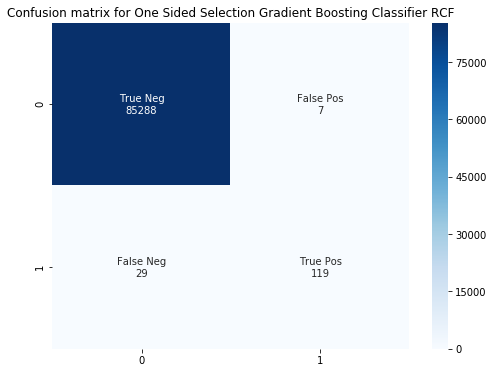

In [171]:
cf_matrix = top_3[0][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for One Sided Selection Gradient Boosting Classifier RCF")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [205]:
print(top_3[0][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.80      0.87       148

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



2. Tomek Links Gradient Boosting Classifier RCF

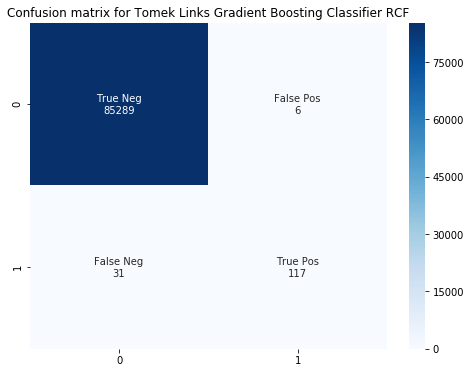

In [202]:
cf_matrix = top_3[1][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for Tomek Links Gradient Boosting Classifier RCF")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [206]:
print(top_3[1][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.95      0.79      0.86       148

    accuracy                           1.00     85443
   macro avg       0.98      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



3. One Sided Selection Gradient Boosting Classifier Random Forest  Selection

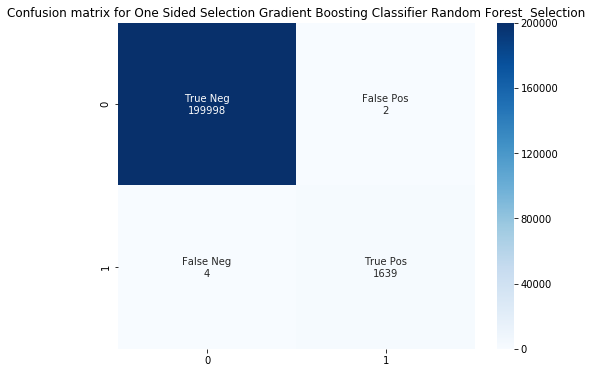

In [126]:
cf_matrix = top_3[2][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for One Sided Selection Gradient Boosting Classifier Random Forest  Selection")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [207]:
print(top_3[2][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.80      0.85       148

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



### Working with dataset 2 - Synthetic dataset generated by the PaySim mobile money simulator

In [61]:
dataset2 = pd.read_csv("dataset2.csv")
dataset2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [62]:
dataset2.shape

(6362620, 11)

In [63]:
dataset2.isnull().values.any()

False

In [64]:
dataset2.drop("isFlaggedFraud",axis=1,inplace=True)


In [65]:
all_zero=list(dataset2.loc[dataset2["isFraud"]==0].index)

#### Since the actual dataset contains around 60 lacs datapoints, we'll use 10 lacs (non-fraud) out of it for our project. We'll keep the fraud ones as it is

In [66]:
sample_zero = np.random.choice(all_zero,1000000,replace=False)

In [67]:
all_one=list(dataset2.loc[dataset2["isFraud"]==1].index)

In [68]:
selected_sample = np.concatenate([sample_zero,all_one])

In [69]:
len(selected_sample)

1008213

In [70]:
new_dataset2 = dataset2.loc[selected_sample]

In [71]:
new_dataset2.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
792161,40,CASH_IN,167893.17,C1482429291,2657271.44,2825164.61,C294651482,1925303.76,1757410.59,0
5309528,373,CASH_OUT,419927.92,C1890321370,21218.00,0.00,C730701416,0.00,419927.92,0
971150,44,CASH_OUT,23433.12,C856112743,96857.00,73423.88,C1746550777,93246.71,116679.83,0
2546292,206,TRANSFER,189426.65,C1304663969,0.00,0.00,C449702174,2152239.28,2341665.93,0
4711943,332,CASH_IN,94723.40,C1076225702,15949506.91,16044230.32,C736564605,883358.12,788634.72,0


In [72]:
y=new_dataset2['isFraud']
new_dataset2.drop('isFraud',axis=1,inplace=True)
X=new_dataset2

Since the destination account balances as zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. Doing so would remove this indicator of fraud and make fraudulent transactions appear genuine. Instead,what we'll do is we replace the value of 0 with -1 which will be more useful to a suitable machine learning (ML) algorithm to detect fraud.

In [73]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), ['oldbalanceDest', 'newbalanceDest']] = - 1

Zero balances could be a strong differentiator between fraudulent and genuine transactions. Getting motivated by this, we create 2 new features  recording errors in the originating and destination accounts for each transaction. These new features might be important in obtaining the best performance from the ML algorithm that we will finally use.

In [74]:
X['errorbalanceOrg'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorbalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

We've observed that log transformation on features provided better results

In [75]:
# log transformed amount
X['ln_amount'] = np.log1p(X['amount'])

In [76]:
# correcting few negative errors
X['errorbalanceOrg'] = X['errorbalanceOrg'].apply(lambda x: 0 if x < 0 else x)

# log transformed origin account balance error
X['ln_errorBalanceOrig'] = np.log1p(X['errorbalanceOrg'])

In [77]:
X['errorbalanceDest'] = X['errorbalanceDest'].apply(lambda x: 0 if x < 0 else x)

# log transformed origin account balance error
X['ln_errorBalanceDest'] = np.log1p(X['errorbalanceDest'])

In [78]:
X["type"].value_counts()

CASH_OUT    355635
PAYMENT     338178
CASH_IN     220661
TRANSFER     87195
DEBIT         6544
Name: type, dtype: int64

In [79]:
X["type_transfer"]=X["type"].replace({'CASH_OUT':0,'PAYMENT':1,'CASH_IN':2,'TRANSFER':3,'DEBIT':4})

In [80]:
X.drop("type",axis=1,inplace=True)

In [81]:
X.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,errorbalanceOrg,errorbalanceDest,ln_amount,ln_errorBalanceOrig,ln_errorBalanceDest,type_transfer
792161,40,167893.17,C1482429291,2657271.44,2825164.61,C294651482,1925303.76,1757410.59,335786.34,335786.34,12.031089,12.724233,12.724233,2
5309528,373,419927.92,C1890321370,21218.00,0.00,C730701416,0.00,419927.92,398709.92,0.00,12.947841,12.895992,0.000000,0
971150,44,23433.12,C856112743,96857.00,73423.88,C1746550777,93246.71,116679.83,0.00,0.00,10.061948,0.000000,0.000000,0
2546292,206,189426.65,C1304663969,0.00,0.00,C449702174,2152239.28,2341665.93,189426.65,0.00,12.151762,12.151762,0.000000,3
4711943,332,94723.40,C1076225702,15949506.91,16044230.32,C736564605,883358.12,788634.72,189446.81,189446.80,11.458727,12.151869,12.151869,2


In [82]:
X.drop(["amount","errorbalanceOrg","errorbalanceDest"],axis=1,inplace=True)


In [83]:
X["type_name"]=X.step

In [84]:
X.loc[(X.nameOrig.str.contains("C")) & (X.nameDest.str.contains("C")),"type_name"]=0
X.loc[(X.nameOrig.str.contains("C")) & (X.nameDest.str.contains("M")),"type_name"]=1
X.loc[(X.nameOrig.str.contains("M")) & (X.nameDest.str.contains("C")),"type_name"]=2
X.loc[(X.nameOrig.str.contains("M")) & (X.nameDest.str.contains("M")),"type_name"]=3

In [85]:
X.drop(["nameOrig","nameDest"],axis=1,inplace=True)

In [86]:
X.head()

,step,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,ln_amount,ln_errorBalanceOrig,ln_errorBalanceDest,type_transfer,type_name
792161,40,2657271.44,2825164.61,1925303.76,1757410.59,12.031089,12.724233,12.724233,2,0
5309528,373,21218.00,0.00,0.00,419927.92,12.947841,12.895992,0.000000,0,0
971150,44,96857.00,73423.88,93246.71,116679.83,10.061948,0.000000,0.000000,0,0
2546292,206,0.00,0.00,2152239.28,2341665.93,12.151762,12.151762,0.000000,3,0
4711943,332,15949506.91,16044230.32,883358.12,788634.72,11.458727,12.151869,12.151869,2,0


In [87]:
#first proceed without step column
step_col = X.step
X.drop("step",axis=1,inplace=True)


In [88]:
X.head()

,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,ln_amount,ln_errorBalanceOrig,ln_errorBalanceDest,type_transfer,type_name
792161,2657271.44,2825164.61,1925303.76,1757410.59,12.031089,12.724233,12.724233,2,0
5309528,21218.00,0.00,0.00,419927.92,12.947841,12.895992,0.000000,0,0
971150,96857.00,73423.88,93246.71,116679.83,10.061948,0.000000,0.000000,0,0
2546292,0.00,0.00,2152239.28,2341665.93,12.151762,12.151762,0.000000,3,0
4711943,15949506.91,16044230.32,883358.12,788634.72,11.458727,12.151869,12.151869,2,0


In [89]:
# dividing into training and testing

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify = y)

In [91]:
X.isnull().values.any()

False

In [92]:
cols=["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","ln_amount","ln_errorBalanceOrig","ln_errorBalanceDest"]
for c in cols:
    ss = StandardScaler()
    ss.fit(X_train.loc[:,str(c)].values.reshape(-1,1))
    transformed1 = ss.transform(X_train.loc[:,str(c)].values.reshape(-1,1))
    print(transformed1.shape)
    X_train["scaled_"+str(c)] = transformed1
    X_train.drop(c,axis=1,inplace=True)
    transformed2 = ss.transform(X_test.loc[:,str(c)].values.reshape(-1,1))
    X_test["scaled_"+str(c)] = transformed2
    X_test.drop(c,axis=1,inplace=True)
    

(806570, 1)
(806570, 1)
(806570, 1)
(806570, 1)
(806570, 1)
(806570, 1)
(806570, 1)


#### 1. Random Undersample

In [93]:
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
all_dataset["X_train_undersample_dataset2"], all_dataset["y_train_undersample_dataset2"] = undersample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(all_dataset["y_train_undersample_dataset2"]))

Counter({0: 6570, 1: 6570})


In [ ]:
training_testing_function(all_dataset["X_train_undersample_dataset2"],all_dataset["y_train_undersample_dataset2"],"Random Undersample dataset 2")

#### 2. Instance Hardness Threshold

In [98]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [99]:
iht = InstanceHardnessThreshold(sampling_strategy='majority', random_state=42)
all_dataset["X_train_res_dataset2"], all_dataset["y_train_res_dataset2"] = iht.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(all_dataset["y_train_res_dataset2"]))

Resampled dataset shape Counter({0: 798005, 1: 6570})


In [ ]:
training_testing_function(all_dataset["X_train_res_dataset2"],all_dataset["y_train_res_dataset2"],"IHT dataset 2")

#### 3. Cluster Centroid

In [101]:
from imblearn.under_sampling import ClusterCentroids

In [360]:
all_dataset["X_cluster_centroids_dataset2"],all_dataset["y_cluster_centroids_dataset2"]  = ClusterCentroids().fit_resample(X_train,y_train)

In [ ]:
training_testing_function(all_dataset["X_cluster_centroids_dataset2"],all_dataset["y_cluster_centroids_dataset2"],"Cluster centroids dataset 2")

#### 4. Near Miss

In [101]:
from imblearn.under_sampling import NearMiss

In [ ]:
all_dataset['X_near_miss_dataset2'],all_dataset['y_near_miss_dataset2'] = NearMiss().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_near_miss_dataset2'],all_dataset['y_near_miss_dataset2'],"Near Miss dataset 2")

#### 5. One Sided Selection

In [103]:
from imblearn.under_sampling import OneSidedSelection

In [ ]:
all_dataset['X_one_sided_selection_dataset2'],all_dataset['y_one_sided_selection_dataset2'] = OneSidedSelection().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_one_sided_selection_dataset2'],all_dataset['y_one_sided_selection_dataset2'],"One Sided Selection dataset 2")

#### 6. Tomek Links

In [105]:
from imblearn.under_sampling import TomekLinks

In [106]:
all_dataset['X_tomek_links_dataset2'],all_dataset['y_tomek_links_dataset2'] = TomekLinks().fit_resample(X_train,y_train)


In [ ]:
training_testing_function(all_dataset['X_tomek_links_dataset2'],all_dataset['y_tomek_links_dataset2'],"Tomek Links dataset 2")

### Oversampling data

#### 1. Random Oversampling

In [108]:
ros = RandomOverSampler(random_state=0)
all_dataset["X_train_random_oversampled_dataset2"], all_dataset["y_train_random_oversampled_dataset2"] = ros.fit_resample(X_train, y_train)

print(sorted(Counter(all_dataset["y_train_random_oversampled_dataset2"]).items()))

[(0, 800000), (1, 800000)]


In [ ]:
training_testing_function(all_dataset["X_train_random_oversampled_dataset2"],all_dataset["y_train_random_oversampled_dataset2"],"Random Oversampled dataset2")

#### 2. SMOTE

In [110]:
from imblearn.over_sampling import SMOTE, ADASYN
all_dataset["X_smote_dataset2"], all_dataset["y_smote_dataset2"] = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(all_dataset["y_smote_dataset2"]).items()))



[(0, 800000), (1, 800000)]


In [ ]:
training_testing_function(all_dataset['X_smote_dataset2'],all_dataset['y_smote_dataset2'],"SMOTE dataset2")

#### 3. ADASYN

In [112]:
all_dataset['X_adasyn_dataset2'],all_dataset['y_adasyn_dataset2'] = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(all_dataset["y_adasyn_dataset2"]).items()))

[(0, 800000), (1, 800090)]


In [ ]:
training_testing_function(all_dataset['X_adasyn_dataset2'],all_dataset['y_adasyn_dataset2'],"ADASYN dataset2")

#### 4. Variations of SMOTE

In [114]:
from imblearn.over_sampling import BorderlineSMOTE,SVMSMOTE,KMeansSMOTE

In [ ]:
all_dataset["X_borderline_smote_dataset2"],all_dataset["y_borderline_smote_dataset2"] = BorderlineSMOTE().fit_resample(X_train,y_train)
all_dataset["X_svm_smote_dataset2"],all_dataset["y_svm_smote_dataset2"] = SVMSMOTE().fit_resample(X_train,y_train)



training_testing_function(all_dataset["X_borderline_smote_dataset2"],all_dataset["y_borderline_smote_dataset2"],"Borderline SMOTE dataset2")
training_testing_function(all_dataset["X_svm_smote_dataset2"],all_dataset["y_svm_smote_dataset2"],"SVM SMOTE dataset2")




### Combination of Undersampling and Oversampling

#### 1. SMOTETomek

In [116]:
from imblearn.combine import SMOTETomek

In [ ]:
all_dataset['X_smote_tomek_dataset2'],all_dataset['y_smote_tomek_dataset2'] = SMOTETomek().fit_resample(X_train,y_train)
training_testing_function(all_dataset['X_smote_tomek_dataset2'],all_dataset['y_smote_tomek_dataset2'],"SMOTE Tomek dataset2")

In [118]:
top_3 = sorted(all_results,key=lambda x: x[2],reverse=True)[:3]
top_3

[('Borderline SMOTE dataset2 VotingClassifier Random Forest  Selection',
  0.9999801629612731,
  0.9987812309567338,
  0.9987827145465611,
  array([[200000,      0],
         [     4,   1639]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00    200000\n           1       1.00      1.00      1.00      1643\n\n    accuracy                           1.00    201643\n   macro avg       1.00      1.00      1.00    201643\nweighted avg       1.00      1.00      1.00    201643\n'),
 ('Tomek Links dataset 2 Gradient Boosting Classifier Random Forest  Selection',
  0.9999702444419097,
  0.9981729598051157,
  0.9987777145465611,
  array([[199998,      2],
         [     4,   1639]], dtype=int64),
  '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00    200000\n           1       1.00      1.00      1.00      1643\n\n    accuracy                           1.00    201643\n   macro

In [119]:
name,acc,f1=[],[],[]
for a,b,c,d,e,f in all_results:
    name.append(a)
    acc.append(b)
    f1.append(c)

cc_result=pd.DataFrame({'name':name,'acc':acc,'f1':f1})
cc_result.to_csv("dataset2_results.csv",index=False)
    

### Confusion matrix of top 3 performers

1. Borderline SMOTE dataset2 VotingClassifier Random Forest  Selection

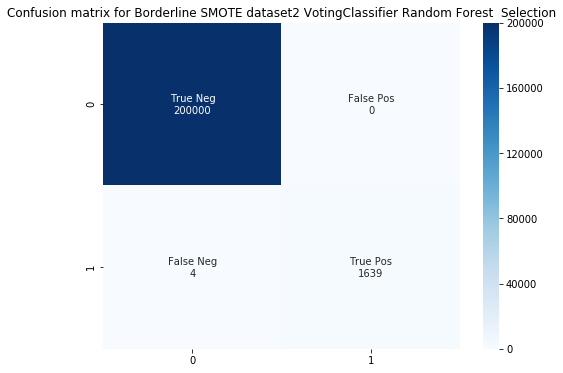

In [120]:
cf_matrix = top_3[0][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for Borderline SMOTE dataset2 VotingClassifier Random Forest  Selection")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [121]:
print(top_3[0][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200000
           1       1.00      1.00      1.00      1643

    accuracy                           1.00    201643
   macro avg       1.00      1.00      1.00    201643
weighted avg       1.00      1.00      1.00    201643



2. Tomek Links dataset 2 Gradient Boosting Classifier Random Forest  Selection

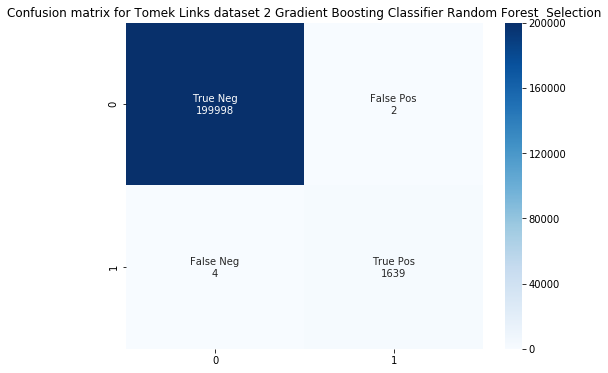

In [122]:
cf_matrix = top_3[1][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for Tomek Links dataset 2 Gradient Boosting Classifier Random Forest  Selection")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [123]:
print(top_3[1][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200000
           1       1.00      1.00      1.00      1643

    accuracy                           1.00    201643
   macro avg       1.00      1.00      1.00    201643
weighted avg       1.00      1.00      1.00    201643



3. Borderline SMOTE dataset2 Gradient Boosting Classifier Random Forest  Selection

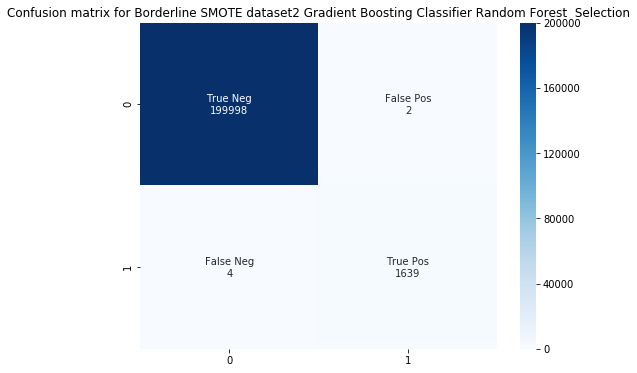

In [124]:
cf_matrix = top_3[2][4]

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,6))
plt.title("Confusion matrix for Borderline SMOTE dataset2 Gradient Boosting Classifier Random Forest  Selection")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show();

Classification report

In [125]:
print(top_3[2][5])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200000
           1       1.00      1.00      1.00      1643

    accuracy                           1.00    201643
   macro avg       1.00      1.00      1.00    201643
weighted avg       1.00      1.00      1.00    201643

